In [1]:
import torch.nn as nn
import torch as tch
import numpy as np, pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("../data/bank.csv")
print("DF Shape:",df.shape)
df.head()

DF Shape: (11162, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [3]:
print("Distribution of Target Values in Dataset -")
df.deposit.value_counts()

Distribution of Target Values in Dataset -


no     5873
yes    5289
Name: deposit, dtype: int64

In [4]:
#Check if we have 'na' values within the dataset
df.isna().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
deposit      0
dtype: int64

In [5]:
#Check the distinct datatypes within the dataset
df.dtypes.value_counts()

object    10
int64      7
dtype: int64

In [6]:
# Extract categorical columns from dataset
categorical_columns = df.select_dtypes(include="object").columns
print("Categorical cols:",list(categorical_columns))
# For each categorical column if values in (Yes/No) convert into a 1/0 Flag
for col in categorical_columns:
    if df[col].nunique() == 2:
        df[col] = np.where(df[col]=="yes",1,0)
df.head()

Categorical cols: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'deposit']


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,0,2343,1,0,unknown,5,may,1042,1,-1,0,unknown,1
1,56,admin.,married,secondary,0,45,0,0,unknown,5,may,1467,1,-1,0,unknown,1
2,41,technician,married,secondary,0,1270,1,0,unknown,5,may,1389,1,-1,0,unknown,1
3,55,services,married,secondary,0,2476,1,0,unknown,5,may,579,1,-1,0,unknown,1
4,54,admin.,married,tertiary,0,184,0,0,unknown,5,may,673,2,-1,0,unknown,1


In [7]:
# For the remaining cateogrical variables;
# create one-hot encoded version of the dataset
new_df = pd.get_dummies(df)
# Define target and predictors for the model
target = "deposit"
predictors = list(set(new_df.columns) - set([target]))
print("new_df.shape:",new_df.shape)
new_df[predictors].head()

new_df.shape: (11162, 49)


,job_services,poutcome_failure,job_retired,month_sep,month_jun,month_oct,day,month_aug,month_jul,month_jan,...,job_unknown,month_dec,poutcome_unknown,age,contact_telephone,marital_married,month_nov,loan,job_student,education_secondary
0,0,0,0,0,0,0,5,0,0,0,...,0,0,1,59,0,1,0,0,0,1
1,0,0,0,0,0,0,5,0,0,0,...,0,0,1,56,0,1,0,0,0,1
2,0,0,0,0,0,0,5,0,0,0,...,0,0,1,41,0,1,0,0,0,1
3,1,0,0,0,0,0,5,0,0,0,...,0,0,1,55,0,1,0,0,0,1
4,0,0,0,0,0,0,5,0,0,0,...,0,0,1,54,0,1,0,0,0,0


In [8]:
# Convert all datatypes within pandas dataframe to Float32
# (Compatibility with PyTorch tensors)
new_df = new_df.astype(np.float32)
# Split dataset into Train/Test [80:20]
X_train,x_test, Y_train,y_test = train_test_split(new_df[predictors],new_df[target],test_size= 0.2)
# Convert Pandas dataframe, first to numpy and then to Torch Tensors
X_train = tch.from_numpy(X_train.values)
x_test  = tch.from_numpy(x_test.values)
Y_train = tch.from_numpy(Y_train.values).reshape(-1,1)
y_test  = tch.from_numpy(y_test.values).reshape(-1,1)
# Print the dataset size to verify
print("X_train.shape:",X_train.shape)
print("x_test.shape:",x_test.shape)
print("Y_train.shape:",Y_train.shape)
print("y_test.shape:",y_test.shape)

X_train.shape: torch.Size([8929, 48])
x_test.shape: torch.Size([2233, 48])
Y_train.shape: torch.Size([8929, 1])
y_test.shape: torch.Size([2233, 1])


In [14]:
# Define function to train the network
def train_network(model,optimizer,loss_function,num_epochs,batch_size,X_train,Y_train,lambda_L1=0.0):
    loss_across_epochs = []
    for epoch in range(num_epochs):
        train_loss= 0.0
        # Explicitly start model training
        model.train()
        for i in range(0,X_train.shape[0],batch_size):
            # Extract train batch from X and Y
            input_data = X_train[i:min(X_train.shape[0],i+batch_size)]
            labels = Y_train[i:min(X_train.shape[0],i+batch_size)]
            
            # set the gradients to zero before starting to do backpropragation
            optimizer.zero_grad()
            
            # Forward pass
            output_data  = model(input_data)
            
            # Calculate loss
            loss = loss_function(output_data, labels)
            L1_loss = 0
            
            # Compute L1 penalty to be added with loss
            for p in model.parameters():
                L1_loss = L1_loss + p.abs().sum()
            
            # Add L1 penalty to loss
            loss = loss + lambda_L1 * L1_loss
            
            # Backpropogate
            loss.backward()
            
            # Update weights
            optimizer.step()
            train_loss += loss.item() * input_data.size(0)
        loss_across_epochs.append(train_loss/X_train.size(0))
        if epoch%100 == 0:
            print("Epoch: {} - Loss:{:.4f}".format(epoch,train_loss/X_train.size(0) ))
    
    return loss_across_epochs

In [10]:
#Define function for evaluating NN
def evaluate_model(model,x_test,y_test,X_train,Y_train,loss_list):
    model.eval() #Explicitly set to evaluate mode
    #Predict on Train and Validation Datasets
    y_test_prob = model(x_test)
    y_test_pred =np.where(y_test_prob>0.5,1,0)
    Y_train_prob = model(X_train)
    Y_train_pred =np.where(Y_train_prob>0.5,1,0)
    #Compute Training and Validation Metrics
    print("\n Model Performance -")
    print("Training Accuracy-",round(accuracy_score(Y_train,Y_train_pred),3))
    print("Training Precision-",round(precision_score(Y_train,Y_train_pred),3))
    print("Training Recall-",round(recall_score(Y_train,Y_train_pred),3))
    print("Training ROCAUC", round(roc_auc_score(Y_train
                                   ,Y_train_prob.detach().numpy()),3))
    print("Validation Accuracy-",round(accuracy_score(y_test,y_test_pred),3))
    print("Validation Precision-",round(precision_score(y_test,y_test_pred),3))
    print("Validation Recall-",round(recall_score(y_test,y_test_pred),3))
    print("Validation ROCAUC", round(roc_auc_score(y_test
                                     ,y_test_prob.detach().numpy()),3))
    print("\n")
    #Plot the Loss curve and ROC Curve
    plt.figure(figsize=(20,5))
    plt.subplot(1, 2, 1)
    plt.plot(loss_list)
    plt.title('Loss across epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.subplot(1, 2, 2)
    #Validation
    fpr_v, tpr_v, _ = roc_curve(y_test, y_test_prob.detach().numpy())
    roc_auc_v = auc(fpr_v, tpr_v)
    #Training
    fpr_t, tpr_t, _ = roc_curve(Y_train, Y_train_prob.detach().numpy())
    roc_auc_t = auc(fpr_t, tpr_t)
    plt.title('Receiver Operating Characteristic:Validation')
    plt.plot(fpr_v, tpr_v, 'b', label = 'Validation AUC = %0.2f' % roc_auc_v)
    plt.plot(fpr_t, tpr_t, 'r', label = 'Training AUC = %0.2f' % roc_auc_t)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

Epoch: 0 - Loss:3.3481

 Model Performance -
Training Accuracy- 0.805
Training Precision- 0.78
Training Recall- 0.824
Training ROCAUC 0.883
Validation Accuracy- 0.804
Validation Precision- 0.772
Validation Recall- 0.818
Validation ROCAUC 0.886




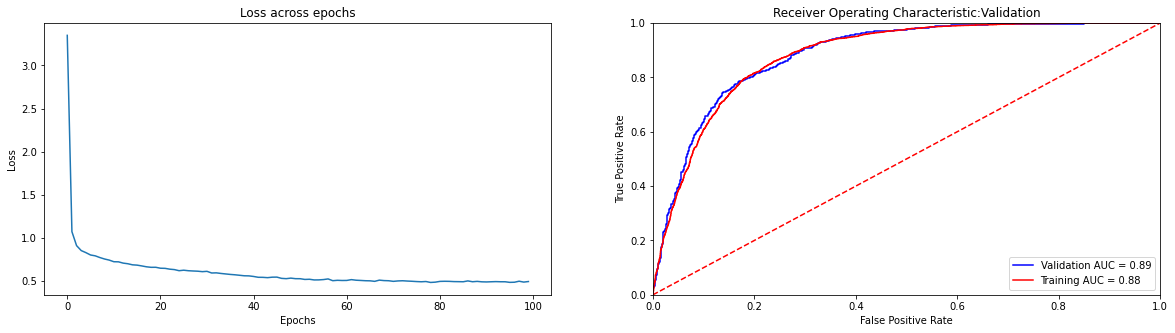

In [17]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        tch.manual_seed(2020)
        self.fc1 = nn.Linear(48, 96)
        self.fc2 = nn.Linear(96, 192)
        self.fc3 = nn.Linear(192, 384)
        self.out = nn.Linear(384, 1)
        self.relu = nn.ReLU()
        self.final = nn.Sigmoid()
        self.drop = nn.Dropout(0.1)  #Dropout Layer
    def forward(self, x):
        op = self.drop(x)  #Dropout for input layer
        op = self.fc1(op)
        op = self.relu(op)
        op = self.drop(op) #Dropout for hidden layer 1
        op = self.fc2(op)
        op = self.relu(op)
        op = self.drop(op) #Dropout for hidden layer 2
        op = self.fc3(op)
        op = self.relu(op)
        op = self.drop(op) #Dropout for hidden layer 3
        op = self.out(op)
        y = self.final(op)
        return y
        
#Define training variables
num_epochs = 100
batch_size= 128
loss_function = nn.BCELoss()  #Binary Crosss Entropy Loss
#Hyperparameters
weight_decay=0.001 #set to 0; no L2 Regularizer; passed into the Optimizer
lambda_L1=0.0001    #Set to 0; no L1 reg; manually added in loss (train_network)
#Create a model instance
model = NeuralNetwork()
#Define optimizer
adam_optimizer = tch.optim.Adam(
    model.parameters(), lr= 0.001, weight_decay=weight_decay)
#Train model
adam_loss = train_network(
    model,adam_optimizer,loss_function,num_epochs,batch_size, 
    X_train,Y_train,lambda_L1=lambda_L1)
#Evaluate model
evaluate_model(model,x_test,y_test,X_train,Y_train,adam_loss)